<a href="https://colab.research.google.com/github/sanadv/Cubixel/blob/main/Cubixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

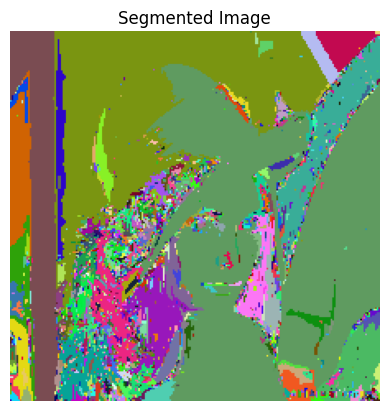

In [ ]:
#Cubixel Segmentation (Original)
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

def calculate_similarity(cube1, cube2):
    # Calculate color similarity using Euclidean distance in color space
    color_distance = np.linalg.norm(cube1 - cube2)

    # Calculate size similarity based on the volume (product of dimensions)
    size1 = np.prod(cube1)
    size2 = np.prod(cube2)
    size_similarity = abs(size1 - size2) / max(size1, size2) if max(size1, size2) > 0 else 0

    # Combine color similarity and size similarity into a single metric
    # You can adjust the weights based on how much you want to prioritize color vs size
    color_weight = 0.3
    size_weight = 1
    similarity_score = (size_weight * size_similarity)

    return similarity_score

def calculate_otsu_threshold(pixels):
    # Convert to grayscale as Otsu's method is typically applied on grayscale images
    grayscale_pixels = rgb2gray(pixels)
    # Flatten the grayscale pixels to apply Otsu's thresholding
    flattened_pixels = grayscale_pixels.flatten()
    # Calculate the Otsu's threshold
    otsu_threshold = threshold_otsu(flattened_pixels)

    # Convert the Otsu's threshold for grayscale to a threshold for each RGB channel
    # Here we assume the threshold for RGB should be higher to account for color variability
    # The factor 1.5 is arbitrary and should be tuned
    color_threshold = otsu_threshold * 1.5

    return color_threshold


def flood_fill(labels, pixels, x, y, label_index, threshold):
    # Begin with the current position
    stack = [(x, y)]
    current_cube = pixels[x, y] / 255.0

    while stack:
        x, y = stack.pop()
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Check all four directions
            nx, ny = x + dx, y + dy
            if 0 <= nx < pixels.shape[0] and 0 <= ny < pixels.shape[1]:
                if labels[nx, ny] == -1:  # Not already labeled
                    neighbor_cube = pixels[nx, ny] / 255.0
                    if calculate_similarity(current_cube, neighbor_cube) < threshold:
                        labels[nx, ny] = label_index
                        stack.append((nx, ny))

# Load the image
img = Image.open('img.jpeg')
img.thumbnail((256, 256))  # Resize for simplicity
pixels = np.array(img)

# Initialize labels for segmentation
labels = -np.ones(pixels.shape[:2], dtype=int)  # Initialize labels with -1
label_count = 0

# Calculate adaptive similarity threshold
similarity_threshold = calculate_otsu_threshold(pixels)

# Apply flood fill for segmentation
for x in range(pixels.shape[0]):
    for y in range(pixels.shape[1]):
        if labels[x, y] == -1:
            labels[x, y] = label_count
            flood_fill(labels, pixels, x, y, label_count, similarity_threshold)
            label_count += 1


colors = np.random.randint(0, 255, (label_count, 3))
#colors = plt.cm.get_cmap('hsv', label_count)

# Apply colors to the segmented image
segmented_image = np.zeros_like(pixels)

for label in range(label_count):
    segmented_image[labels == label] = colors[label]
    #segmented_image[labels == label] = np.array(colors(label)[:3]) * 255

plt.imshow(segmented_image)
plt.title('Segmented Image')
plt.axis('off')
plt.show()


2.15193772315979


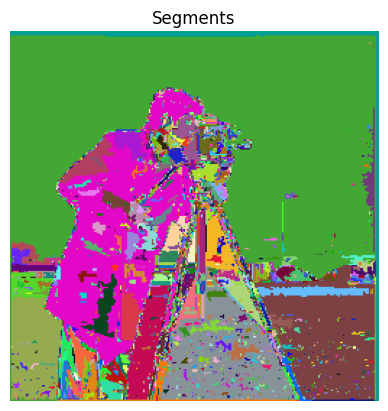

In [ ]:
#Faster Segmentation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import time


def calculate_similarity(volume1, volume2):
    # Directly compute size similarity from precomputed volumes
    size_similarity = abs(volume1 - volume2) / max(volume1, volume2) if max(volume1, volume2) > 0 else 0
    return size_similarity

def calculate_otsu_threshold(grayscale_pixels):
    # Calculate the Otsu's threshold using already flattened grayscale pixels
    otsu_threshold = threshold_otsu(grayscale_pixels)
    color_threshold = otsu_threshold * 1.5
    return color_threshold

def flood_fill(labels, volumes, x, y, label_index, threshold):
    stack = [(x, y)]
    current_volume = volumes[x, y]

    while stack:
        x, y = stack.pop()
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < volumes.shape[0] and 0 <= ny < volumes.shape[1]:
                if labels[nx, ny] == -1:
                    neighbor_volume = volumes[nx, ny]
                    if calculate_similarity(current_volume, neighbor_volume) < threshold:
                        labels[nx, ny] = label_index
                        stack.append((nx, ny))

# Load the image
img = Image.open('img3.jpg')
img.thumbnail((256, 256))  # Resize for simplicity
pixels = np.array(img)
grayscale_pixels = rgb2gray(pixels).flatten()  # Precompute grayscale pixels

# Precompute volumes for all pixels
cube_colors = pixels / 255.0
volumes = np.prod(cube_colors, axis=-1)

# Initialize labels for segmentation
labels = -np.ones(pixels.shape[:2], dtype=int)
label_count = 0

# Calculate adaptive similarity threshold
similarity_threshold = calculate_otsu_threshold(grayscale_pixels)
start_time = time.time()


# Apply flood fill for segmentation
for x in range(pixels.shape[0]):
    for y in range(pixels.shape[1]):
        if labels[x, y] == -1:
            labels[x, y] = label_count
            flood_fill(labels, volumes, x, y, label_count, similarity_threshold)
            label_count += 1

# Generate random colors for each label
colors = np.random.randint(0, 255, (label_count, 3))

# Apply colors to the segmented image using numpy indexing
segmented_image = np.zeros_like(pixels)
for label in range(label_count):
    segmented_image[labels == label] = colors[label]
execution_time = (time.time() - start_time)   # Convert to milliseconds

print(execution_time)
plt.imshow(segmented_image)
plt.title('Segments')
plt.axis('off')
plt.show()


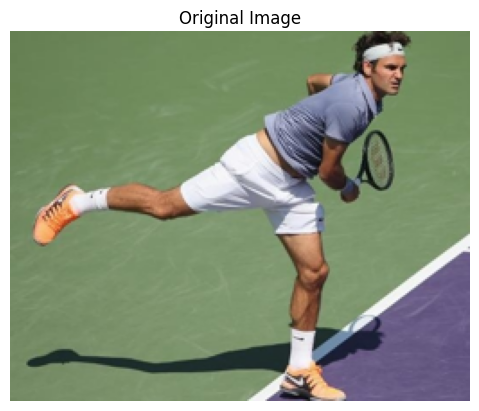

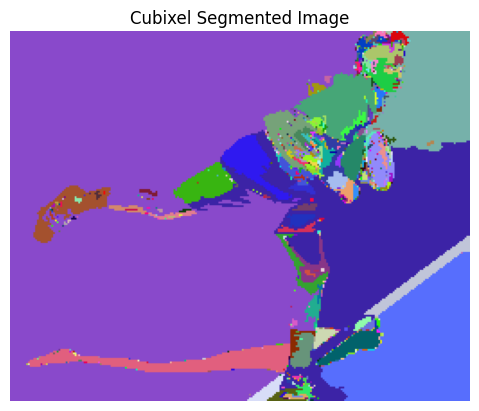

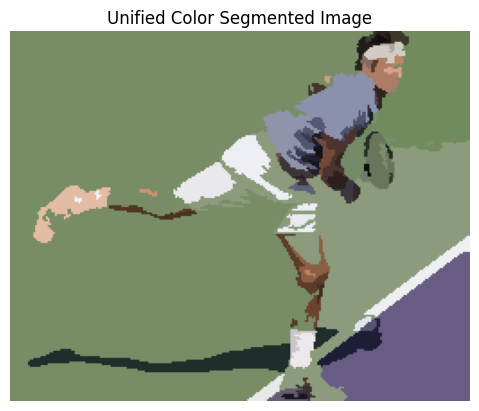

In [ ]:

#Unify color Segmentation
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from collections import deque

def calculate_similarity(cube1, cube2):
    # Calculate color similarity using Euclidean distance in color space
    color_distance = np.linalg.norm(cube1 - cube2)

    # Calculate size similarity based on the volume (product of dimensions)
    size1 = np.prod(cube1)
    size2 = np.prod(cube2)
    size_similarity = abs(size1 - size2) / max(size1, size2) if max(size1, size2) > 0 else 0

    # Combine color similarity and size similarity into a single metric
    # You can adjust the weights based on how much you want to prioritize color vs size
    color_weight = 0.3
    size_weight = 1
    similarity_score =(size_weight * size_similarity)

    return similarity_score

def calculate_otsu_threshold(pixels):
    # Convert to grayscale as Otsu's method is typically applied on grayscale images
    grayscale_pixels = rgb2gray(pixels)
    # Flatten the grayscale pixels to apply Otsu's thresholding
    flattened_pixels = grayscale_pixels.flatten()
    # Calculate the Otsu's threshold
    otsu_threshold = threshold_otsu(flattened_pixels)

    # Convert the Otsu's threshold for grayscale to a threshold for each RGB channel
    # Here we assume the threshold for RGB should be higher to account for color variability
    # The factor 1.5 is arbitrary and should be tuned
    color_threshold = otsu_threshold * 1.5

    return color_threshold


def flood_fill(labels, pixels, x, y, label_index, threshold):
    # Begin with the current position
    stack = [(x, y)]
    current_cube = pixels[x, y] / 255.0

    while stack:
        x, y = stack.pop()
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Check all four directions
            nx, ny = x + dx, y + dy
            if 0 <= nx < pixels.shape[0] and 0 <= ny < pixels.shape[1]:
                if labels[nx, ny] == -1:  # Not already labeled
                    neighbor_cube = pixels[nx, ny] / 255.0
                    if calculate_similarity(current_cube, neighbor_cube) < threshold:
                        labels[nx, ny] = label_index
                        stack.append((nx, ny))

# Load the image
img = Image.open('rr.jpg')
img.thumbnail((256, 256))  # Resize for simplicity
pixels = np.array(img)

# Initialize labels for segmentation
labels = -np.ones(pixels.shape[:2], dtype=int)  # Initialize labels with -1
label_count = 0

# Calculate adaptive similarity threshold
similarity_threshold = calculate_otsu_threshold(pixels)

# Apply flood fill for segmentation
for x in range(pixels.shape[0]):
    for y in range(pixels.shape[1]):
        if labels[x, y] == -1:
            labels[x, y] = label_count
            flood_fill(labels, pixels, x, y, label_count, similarity_threshold)
            label_count += 1


colors = np.random.randint(0, 255, (label_count, 3))
#colors = plt.cm.get_cmap('hsv', label_count)

# Apply colors to the segmented image
segmented_image = np.zeros_like(pixels)

for label in range(label_count):
    segmented_image[labels == label] = colors[label]
    #segmented_image[labels == label] = np.array(colors(label)[:3]) * 255

def find_nearest_label(labels, x, y):
    visited = set()
    queue = deque([(x, y)])

    while queue:
        cur_x, cur_y = queue.popleft()
        # Check if we've already visited this position
        if (cur_x, cur_y) in visited:
            continue
        visited.add((cur_x, cur_y))

        # Check if the current position has a valid label
        if labels[cur_y, cur_x] != -1:
            return labels[cur_y, cur_x]

        # Add neighboring positions to the queue to visit them next
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Check all four directions
            next_x, next_y = cur_x + dx, cur_y + dy
            if (0 <= next_x < labels.shape[1] and
                0 <= next_y < labels.shape[0] and
                (next_x, next_y) not in visited):
                queue.append((next_x, next_y))

    # If no label found, return a default label
    return -1  # This can be an indication that something went wrong

def merge_segments_and_unify_colors(labels, pixels, min_size):
    # Calculate initial unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)

    # Create a mask for small segments to be merged
    mask_small_segments = counts < min_size
    small_segments = unique_labels[mask_small_segments]

    # Mark small segments with a special label for merging
    for small_label in small_segments:
        labels[labels == small_label] = -1  # Marking for later merging

    # Compute average color for the remaining segments
    average_colors = {}
    for label in unique_labels[~mask_small_segments]:
        mask = labels == label
        average_colors[label] = np.mean(pixels[mask], axis=0)

    # Assign new labels to all segments, including small ones to be merged
    new_label = 0
    relabeled = np.full(labels.shape, -1, dtype=int)  # Ensuring relabeled is 2D
    new_average_colors = {}
    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            current_label = labels[y, x]
            if relabeled[y, x] == -1:
                # If it's a small segment, find the nearest large segment
                if current_label == -1:
                    label = find_nearest_label(labels, x, y)  # Using BFS function
                else:
                    label = current_label

                # Assign the new label and update color
                relabeled[y, x] = new_label
                new_average_colors[new_label] = average_colors.get(label, np.random.randint(0, 255, 3))
                new_label += 1

    # Create a new image to store the unified color segments
    new_image = np.zeros_like(pixels)
    for label, color in new_average_colors.items():
        new_image[relabeled == label] = color

    return new_image


# Note that min_size should be set according to your specific use case
uni = merge_segments_and_unify_colors(labels, pixels, 8)
# Display the uni image

# Display the uni image
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(segmented_image)
plt.title('Cubixel Segmented Image')
plt.axis('off')
plt.show()
# Display the unified color segments image
plt.imshow(uni)
plt.title('Unified Color Segmented Image')
plt.axis('off')
plt.show()


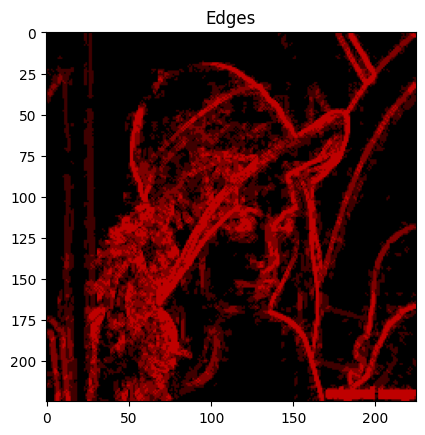

In [ ]:
#Edge Detection (Original)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image
import numpy as np
#Third Way
def draw_cube(ax, position, size, color, edge_color):
    # Define the vertices of the cube
    #B G R
    ox, oy, oz = position
    l, w, h = size
    x = [ox, ox, ox+l, ox+l, ox]
    y = [oy, oy+w, oy+w, oy, oy]
    z = [oz, oz, oz, oz, oz+h]
    vertices = [list(zip(x, y, z))]

    # Create a 3D cube

def calculate_cube_position(x, y, size):
    # Calculate the absolute position of a cube in 3D space, considering only size for simplicity
    return np.array([x, y, 0]) + 0.5 * np.array(size)

def calculate_adaptive_threshold(pixels):
    # Improved calculation of an adaptive threshold based on the properties of the image
    cube_sizes = pixels / 255
    avg_size = np.mean(cube_sizes)
    size_variability = np.std(cube_sizes)
    color_diversity = np.std(pixels, axis=(0, 1))
    color_contrast = np.mean(np.gradient(pixels, axis=(0, 1)))
    return avg_size + size_variability + (np.mean(color_diversity) + color_contrast) / 255

def calculate_color_difference(color1, color2):
    # Calculate color difference using a method like the Euclidean distance
    return np.linalg.norm(color1 - color2)

gap_levels = 4  # Number of gap levels
def is_significant_gap0(pos1, size1, color1, pos2, size2, color2, threshold):
    # Calculate the gap considering size, position, and color differences
    size_gap = np.max(np.abs((pos1 + size1) - (pos2 - size2)))
    color_gap = calculate_color_difference(color1, color2)
    total_gap = size_gap + color_gap

    # Define levels of gap significance
    if total_gap > threshold * 2:
        return 3  # Maximum gap
    elif total_gap > threshold:
        return 2  # Moderate gap
    elif total_gap > threshold / 2:
        return 1  # Minor gap
    else:
        return 0  # No significant gap

def is_significant_gap( size1, size2, threshold):

        # Calculate volumes
        volume1 = np.prod(size1)
        volume2 = np.prod(size2)

        # Calculate aspect ratios
        aspect_ratio1 = size1 / np.max(size1)
        aspect_ratio2 = size2 / np.max(size2)

        # Calculate surface areas
        surface_area1 = 2 * (size1[0]*size1[1] + size1[0]*size1[2] + size1[1]*size1[2])
        surface_area2 = 2 * (size2[0]*size2[1] + size2[0]*size2[2] + size2[1]*size2[2])

        # Compute similarity metrics
        volume_diff = np.abs(volume1 - volume2)
        aspect_ratio_diff = np.linalg.norm(aspect_ratio1 - aspect_ratio2)
        surface_area_diff = np.abs(surface_area1 - surface_area2)

        # Aggregate the differences
        total_diff = volume_diff + aspect_ratio_diff + surface_area_diff

        # Define levels of gap significance
        if total_diff > threshold * 2:
            return 3  # Maximum gap
        elif total_diff > threshold:
            return 2  # Moderate gap
        elif total_diff > threshold / 2:
            return 1  # Minor gap
        else:
            return 0  # No significant gap


# Load the image
img = Image.open('img.jpeg')
img.thumbnail((256, 256))  # Resize for simplicity
pixels = np.array(img)

# Create an empty image to highlight gaps
gap_image = np.zeros_like(pixels)

adaptive_threshold = calculate_adaptive_threshold(pixels)
# Process each pixel and detect significant gaps
# Process each pixel and detect significant gaps
for x in range(pixels.shape[0]):
    for y in range(pixels.shape[1]):
        r, g, b = pixels[x, y, :3]
        #color1 = np.array([r, g, b]) / 255
        size1 = np.array([b, g, r]) / 255
        #cube_pos1 = calculate_cube_position(x, y, size1)

        # Check for significant gaps with all adjacent cubes
        neighbors = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        max_gap_level = 0
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < pixels.shape[0] and 0 <= ny < pixels.shape[1]:
                r2, g2, b2 = pixels[nx, ny, :3]
                #color2 = np.array([r2, g2, b2]) / 255
                size2 = np.array([b2, g2, r2]) / 255
                #cube_pos2 = calculate_cube_position(nx, ny, size2)

                gap_level = is_significant_gap( size1, size2, adaptive_threshold)
                max_gap_level = max(max_gap_level, gap_level)

        if max_gap_level:
            gap_color_intensity = 255 * max_gap_level / gap_levels
            gap_image[x, y] = [gap_color_intensity, 0,0]

# Display the gap image
gap_img = Image.fromarray(gap_image, 'RGB')
plt.imshow(gap_img)
plt.title('Edges')
plt.show()


In [ ]:
#Faster edges
# Vectorized computation of cube sizes and properties for all pixels.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image
import numpy as np

# Load the image
img = Image.open('paper.jpg')
img.thumbnail((256, 256))  # Resize for simplicity
pixels = np.array(img)

# Create an empty image to highlight gaps
gap_image = np.zeros_like(pixels)

cube_sizes = pixels / 255.0
volumes = np.prod(cube_sizes, axis=-1)
aspect_ratios = cube_sizes / np.max(cube_sizes, axis=-1, keepdims=True)
surface_areas = 2 * (cube_sizes[..., 0] * cube_sizes[..., 1] + cube_sizes[..., 0] * cube_sizes[..., 2] + cube_sizes[..., 1] * cube_sizes[..., 2])
def calculate_adaptive_threshold(pixels):
    # Improved calculation of an adaptive threshold based on the properties of the image
    cube_sizes = pixels / 255
    avg_size = np.mean(cube_sizes)
    size_variability = np.std(cube_sizes)
    color_diversity = np.std(pixels, axis=(0, 1))
    color_contrast = np.mean(np.gradient(pixels, axis=(0, 1)))
    # Combine these factors into a more complex threshold calculation
    return avg_size + size_variability + (np.mean(color_diversity) + color_contrast) / 255

# Calculate the adaptive threshold once since it is constant for the image.
adaptive_threshold = calculate_adaptive_threshold(pixels)

# Initialize the gap image as zeros.
gap_image = np.zeros_like(pixels)

# Precompute the relative indices for neighbors to avoid recomputation.
neighbors = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]

# Loop over the pixels, but skip border pixels to avoid boundary checks.
for x in range(1, pixels.shape[0] - 1):
    for y in range(1, pixels.shape[1] - 1):
        size1 = cube_sizes[x, y]
        volume1 = volumes[x, y]
        aspect_ratio1 = aspect_ratios[x, y]
        surface_area1 = surface_areas[x, y]

        max_gap_level = 0

        # Process each neighbor.
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy

            size2 = cube_sizes[nx, ny]
            volume2 = volumes[nx, ny]
            aspect_ratio2 = aspect_ratios[nx, ny]
            surface_area2 = surface_areas[nx, ny]

            # Compute similarity metrics.
            volume_diff = np.abs(volume1 - volume2)
            aspect_ratio_diff = np.linalg.norm(aspect_ratio1 - aspect_ratio2)
            surface_area_diff = np.abs(surface_area1 - surface_area2)
            total_diff = volume_diff + aspect_ratio_diff + surface_area_diff

            # Define levels of gap significance.
            gap_level = 0
            if total_diff > adaptive_threshold * 2:
                gap_level = 3  # Maximum gap
            elif total_diff > adaptive_threshold:
                gap_level = 2  # Moderate gap
            elif total_diff > adaptive_threshold / 2:
                gap_level = 1  # Minor gap

            max_gap_level = max(max_gap_level, gap_level)

        # Assign the gap color intensity based on the highest gap level found.
        if max_gap_level:
            gap_color_intensity = 255 * max_gap_level / 3  # Assuming 3 gap levels.
            gap_image[x, y] = [gap_color_intensity, 0, 0]
gap_img = Image.fromarray(gap_image, 'RGB')
plt.imshow(gap_img)
plt.title('Edges')
plt.show()

4.7137861251831055


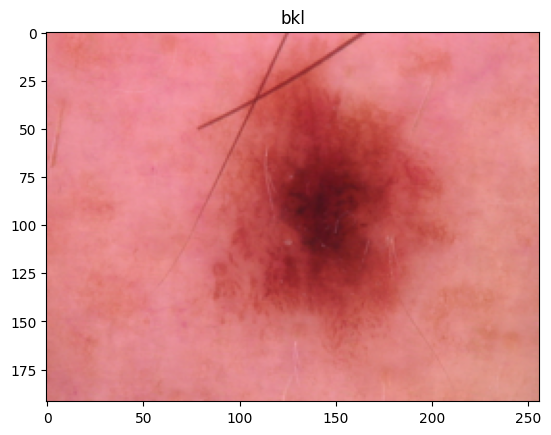

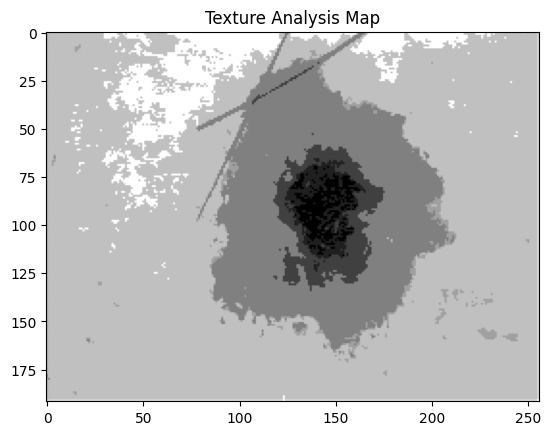

In [ ]:
#Texture Analysis
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from PIL import Image
import numpy as np
import time
#Texture Analisis
def draw_cube(ax, position, size, color, edge_color):
    # Define the vertices of the cube
    #B G R
    ox, oy, oz = position
    l, w, h = size
    x = [ox, ox, ox+l, ox+l, ox]
    y = [oy, oy+w, oy+w, oy, oy]
    z = [oz, oz, oz, oz, oz+h]
    vertices = [list(zip(x, y, z))]

    # Create a 3D cube


def calculate_color_difference(color1, color2):
    # Calculate color difference using a method like the Euclidean distance
    return np.linalg.norm(color1 - color2)

gap_levels = 5  # Number of gap levels
def is_significant_gap0(pos1, size1, color1, pos2, size2, color2, threshold):
    # Calculate the gap considering size, position, and color differences
    size_gap = np.max(np.abs((pos1 - size1) - (pos2 - size2)))
    color_gap = calculate_color_difference(color1, color2)
    total_gap = size_gap + color_gap

    # Define levels of gap significance
    if total_gap > threshold * 2:
        return 3  # Maximum gap
    elif total_gap > threshold:
        return 2  # Moderate gap
    elif total_gap > threshold / 2:
        return 1  # Minor gap
    else:
        return 0  # No significant gap

def calculate_cube_position(x, y, size):
    # Calculate the absolute position of a cube in 3D space, considering only size for simplicity
    return np.array([x, y,0]) +  np.array(size)

def calculate_adaptive_threshold(pixels):
    # Improved calculation of an adaptive threshold based on the properties of the image
    cube_sizes = pixels / 255
    avg_size = np.mean(cube_sizes)
    size_variability = np.std(cube_sizes)
    color_diversity = np.std(pixels, axis=(0, 1))
    color_contrast = np.mean(np.gradient(pixels, axis=(0, 1)))
    return avg_size + size_variability + (np.mean(color_diversity) + color_contrast) / 255

def is_significant_gap( pos1,cubixel1,pos2, cubixe2, threshold):
    # Calculate the gap considering size, position, and color differences
    size_gap = max(np.abs((pos1+ cubixel1) - (pos2-cubixe2)))
    # Define more sensitive levels of gap significance
    gap_levels = 3  # You can adjust this number for more or fewer levels
    for level in range(gap_levels, 0, -1):
        if size_gap > threshold * (level / gap_levels)*2:
            return level
    return 0


def texture_analysis(pixels):
    height, width, _ = pixels.shape
    texture_map = np.zeros((height, width))

    adaptive_threshold = calculate_adaptive_threshold(pixels)

    for x in range(height):
        for y in range(width):
            r, g, b = pixels[x, y, :3]
            color1 = np.array([r, g, b]) / 255
            size1 = np.array([b, g, r]) / 255
            cube_pos1 = calculate_cube_position(x, y, size1)

            gap_values = []
            for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1)]:  # Check adjacent pixels
                nx, ny = x + dx, y + dy
                if 0 <= nx < height and 0 <= ny < width:
                    r2, g2, b2 = pixels[nx, ny, :3]
                    color2 = np.array([r2, g2, b2]) / 255
                    size2 = np.array([b2, g2, r2]) / 255
                    cube_pos2 = calculate_cube_position(nx, ny, size2)
                    gap = is_significant_gap(cube_pos1, size1, cube_pos2, size2, adaptive_threshold)
                    gap_values.append(gap)

            # Example: classify texture based on average gap
            avg_gap = np.mean(gap_values)
            texture_map[x, y] = avg_gap  # Or use a more complex classification scheme

    return texture_map

# Load and process the image
img = Image.open('ISIC_0024306.jpg')
img.thumbnail((256, 256))
pixels = np.array(img)
start = time.time()
texture_map = texture_analysis(pixels)
print(time.time() - start)
# Display the texture map
plt.imshow(img)
plt.title('bkl')
plt.show()
# Display the texture map
plt.imshow(texture_map,cmap='gray')
plt.title('Texture Analysis Map')
plt.show()


In [ ]:
#Feature Selection Model 1 (RGB Edge Detection)
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

class CubixelEdgeDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CubixelEdgeDetectionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)
        gap_images = tf.map_fn(lambda x: self.extract_features(x[0], x[1]), (inputs, adaptive_thresholds), dtype=tf.float32)
        return gap_images


    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Vectorized computation of cube sizes
        cube_sizes = self.calculate_cube_sizes(image)  # [height, width, channels]

        # Compute gap differences in a vectorized manner
        gap_differences = self.compute_gap_differences(cube_sizes, threshold, height, width)

        # Edge detection: Identify areas with high gap differences
        edge_image = self.detect_edges(gap_differences)

        return edge_image

    @staticmethod
    def compute_gap_differences(cube_sizes, threshold, height, width):
        # Define shifts for neighbor comparison
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]

        # Compute gap differences using shifted cube sizes
        gap_differences = tf.zeros([height, width, 3], dtype=tf.float32)  # Updated to have 3 channels
        for dx, dy in shifts:
            shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
            gap_differences += tf.abs(cube_sizes - shifted_sizes)

        # Normalize gap differences
        max_gap_difference = tf.reduce_max(gap_differences, axis=[-1], keepdims=True)  # Updated axis for reduction
        normalized_gap_differences = (gap_differences / max_gap_difference) * threshold

        return normalized_gap_differences

    @staticmethod
    def detect_edges(gap_differences):
        # Apply a threshold to identify edges
        edges = tf.cast(gap_differences > 1.0, tf.float32)  # Adjust the threshold as needed

        # Optionally, expand edge dimensions to match the original image's channel count
        edges_expanded = tf.stack([edges, edges, edges], axis=-1)

        return edges_expanded


    @staticmethod
    def calculate_cube_sizes(image):
        return tf.reverse(image, axis=[-1]) / 255  # [b, g, r]
    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

    # @staticmethod
    # def compute_gaps_vectorized(image, cube_positions, cube_sizes, threshold, height, width):
    #     # Define shifts for neighbor comparison
    #     shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]

    #     # Compute gaps using shifted positions and sizes
    #     gap_image = tf.zeros([height, width, 3], dtype=tf.float32)
    #     for dx, dy in shifts:
    #         shifted_positions = tf.roll(cube_positions, shift=[dx, dy], axis=[0, 1])
    #         shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
    #         gap_image += tf.cast(tf.abs(image - shifted_sizes) > threshold, tf.float32)

    #     return gap_image
    # @staticmethod
    # def calculate_cube_positions(height, width):
    #     y_coords, x_coords = tf.meshgrid(tf.range(width), tf.range(height))
    #     return tf.stack([tf.cast(x_coords, tf.float32), tf.cast(y_coords, tf.float32), tf.zeros([height, width])], axis=-1)
    # def compute_detailed_gaps(self, expanded_image, cube_positions, cube_sizes, threshold, height, width):
    #     # Define an expanded range of shifts for a larger neighborhood comparison
    #     extended_shifts = [(dx, dy) for dx in range(-2, 3) for dy in range(-2, 3) if not (dx == 0 and dy == 0)]

    #     # Initialize gap image
    #     detailed_gap_image = tf.zeros([height, width, 3], dtype=tf.float32)

    #     # Compute gaps with extended neighborhood
    #     for dx, dy in extended_shifts:
    #         shifted_positions = tf.roll(cube_positions, shift=[dx, dy], axis=[0, 1])
    #         shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
    #         detailed_gap_image += tf.cast(tf.abs(expanded_image - shifted_sizes) > threshold, tf.float32)

    #     # Further processing can be added here if needed
    #     return detailed_gap_image


# Define the input shape
input_shape = (32, 32, 3)  # Example input shape, adjust as needed

# Define the model
inputs = Input(shape=input_shape)

# Convolutional and MaxPooling layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


# Custom 3D Cube Layer
cube_layer = CubixelEdgeDetectionLayer()(inputs)
flattened_cube_output = Flatten()(cube_layer)

# Concatenate with previous flattened layer
concatenated = Concatenate()([flattened_cube_output, Flatten()(x)])




# Output layer
outputs = Dense(10, activation='softmax')(concatenated)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
model.summary()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")



In [ ]:
#Feature Selection Model 2 (RGBHSVCubixelLayer)
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow as tf
import tensorflow as tf
import numpy as np
class RGBHSVCubixelLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RGBHSVCubixelLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate adaptive thresholds
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)

        # Extract features for each image and threshold pair
        features = tf.map_fn(lambda x: self.extract_features(x[0], x[1]),
                             (inputs, adaptive_thresholds), dtype=tf.float32)
        return features

    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Separate processing of RGB and HSV cube sizes
        rgb_cube_sizes = self.calculate_rgb_cube_sizes(image)
        hsv_cube_sizes = self.calculate_hsv_cube_sizes(image)

        # Calculate properties for RGB and HSV separately
        rgb_properties = self.calculate_cube_properties(rgb_cube_sizes)
        hsv_properties = self.calculate_cube_properties(hsv_cube_sizes)

        # Compute similarities for RGB and HSV separately
        rgb_similarities = self.compute_similarity(rgb_properties, threshold, height, width)
        hsv_similarities = self.compute_similarity(hsv_properties, threshold, height, width)

        # Combine or process the similarities
        combined_similarities = tf.concat([rgb_similarities, hsv_similarities], axis=-1)
        edge_image = self.detect_edges(combined_similarities)

        return edge_image

    @staticmethod
    def calculate_rgb_cube_sizes(image):
        # Calculate RGB cube sizes only
        rgb_cube_sizes = image / 255  # Normalizing the RGB values
        return rgb_cube_sizes

    @staticmethod
    def calculate_hsv_cube_sizes(image):
        # Convert to HSV and calculate HSV cube sizes
        hsv_cube_sizes = tf.image.rgb_to_hsv(image)
        return hsv_cube_sizes

    @staticmethod
    def calculate_cube_properties(cube_sizes):
        # Placeholder method to calculate cube properties like volume, aspect ratio, etc.
        # Replace with actual property calculations
        volume = tf.reduce_prod(cube_sizes, axis=-1)  # Simplified volume calculation
        aspect_ratio = cube_sizes[..., 0] / cube_sizes[..., 1]  # Simplified aspect ratio
        surface_area = cube_sizes[..., 0] * cube_sizes[..., 1]  # Simplified surface area

        # Combine all properties
        combined_properties = tf.stack([volume, aspect_ratio, surface_area], axis=-1)
        return combined_properties

    @staticmethod
    def compute_similarity(cube_properties, threshold, height, width):
        # Placeholder method for similarity computation
        # Initialize with zeros
        similarity = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute differences in cube properties (placeholder logic)
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        for dx, dy in shifts:
            shifted_properties = tf.roll(cube_properties, shift=[dx, dy], axis=[0, 1])
            similarity += tf.abs(cube_properties - shifted_properties)

        # Normalize similarity
        max_similarity = tf.reduce_max(similarity, axis=[-1], keepdims=True)
        normalized_similarity = (similarity / max_similarity) * threshold
        return normalized_similarity

    @staticmethod
    def detect_edges(similarity):
        # Placeholder for edge detection or other feature extraction
        edges = tf.cast(similarity > 1.0, tf.float32)  # Threshold for edge detection
        return edges
    @staticmethod
    def calculate_adaptive_threshold(pixels):
        # Placeholder for adaptive threshold calculation
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        cnn_features, similarity_features = inputs

        # Resize similarity features to match cnn_features spatial dimensions
        similarity_features_resized = tf.image.resize(
            similarity_features, (tf.shape(cnn_features)[1], tf.shape(cnn_features)[2])
        )

        # Expand dimensions to match cnn_features
        similarity_features_expanded = tf.expand_dims(similarity_features_resized, -1)

        # Reduce the expanded similarity features to the channel size of cnn_features
        similarity_features_reduced = tf.reduce_mean(similarity_features_expanded, axis=-2)

        # Apply attention
        attended_features = cnn_features * similarity_features_reduced

        return attended_features





# Define the input shape and the model
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Convolutional Stream (Original Image Data)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Custom3DCubeLayer Output (Similarity Matrix)
cube_layer_output = RGBHSVCubixelLayer()(inputs)
cube_layer_output = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(cube_layer_output)
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)
# Additional downsampling to match 'x' dimensions
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)

# Merge the Convolutional Stream with Cube Layer Output
merged = Concatenate()([x, cube_layer_output])

# Continue with further Convolutional Layers
y = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(merged)
y = MaxPooling2D(pool_size=(2, 2))(y)

# Flatten and add Dense Layers
y = Flatten()(y)
y = Dense(128, activation='relu')(y)

# Output layer
outputs = Dense(10, activation='softmax')(y)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Create the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")


# Normalize the data
x_train_normalized = x_train.astype("float32") / 255

# Initialize the custom layer
custom_layer = RGBHSVCubixelLayer()
# Apply the custom layer to the first 10 images
processed_images = custom_layer(x_train_normalized[:10])
rgb_similarities = processed_images[..., 3:]

# Set up the plotting
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Processed image (RGB similarities)
    plt.subplot(2, 10, i + 11)
    plt.imshow(rgb_similarities[i])
    plt.title("RGB Similarities")
    plt.axis("off")

# Display the plot
plt.show()

In [ ]:
#Feature Selection Model 2 (HSVCubixelLayer No RGB)
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow as tf
import tensorflow as tf
import numpy as np
class HSVCubixelLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HSVCubixelLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate adaptive thresholds
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)

        # Extract features for each image and threshold pair
        features = tf.map_fn(lambda x: self.extract_features(x[0], x[1]),
                             (inputs, adaptive_thresholds), dtype=tf.float32)
        return features

    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Separate processing of RGB and HSV cube sizes
        hsv_cube_sizes = self.calculate_hsv_cube_sizes(image)

        # Calculate properties for RGB and HSV separately
        hsv_properties = self.calculate_cube_properties(hsv_cube_sizes)

        # Compute similarities for RGB and HSV separately
        hsv_similarities = self.compute_similarity(hsv_properties, threshold, height, width)

        # Combine or process the similarities
        edge_image = self.detect_edges(hsv_similarities)

        return edge_image


    @staticmethod
    def calculate_hsv_cube_sizes(image):
        # Convert to HSV and calculate HSV cube sizes
        hsv_cube_sizes = tf.image.rgb_to_hsv(image)
        return hsv_cube_sizes

    @staticmethod
    def calculate_cube_properties(cube_sizes):
        volume = tf.reduce_prod(cube_sizes, axis=-1)
        aspect_ratio = cube_sizes[..., 0] / cube_sizes[..., 1]
        surface_area = cube_sizes[..., 0] * cube_sizes[..., 1]

        # Combine all properties
        combined_properties = tf.stack([volume, aspect_ratio, surface_area], axis=-1)
        return combined_properties

    @staticmethod
    def compute_similarity(cube_properties, threshold, height, width):
        # Initialize with zeros
        similarity = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute differences in cube properties (placeholder logic)
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        for dx, dy in shifts:
            shifted_properties = tf.roll(cube_properties, shift=[dx, dy], axis=[0, 1])
            similarity += tf.abs(cube_properties - shifted_properties)

        # Normalize similarity
        max_similarity = tf.reduce_max(similarity, axis=[-1], keepdims=True)
        normalized_similarity = (similarity / max_similarity) * threshold
        return normalized_similarity

    @staticmethod
    def detect_edges(similarity):
        edges = tf.cast(similarity > 1.0, tf.float32)  # Threshold for edge detection
        return edges
    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        cnn_features, similarity_features = inputs

        # Resize similarity features to match cnn_features spatial dimensions
        similarity_features_resized = tf.image.resize(
            similarity_features, (tf.shape(cnn_features)[1], tf.shape(cnn_features)[2])
        )

        # Expand dimensions to match cnn_features
        similarity_features_expanded = tf.expand_dims(similarity_features_resized, -1)

        # Reduce the expanded similarity features to the channel size of cnn_features
        similarity_features_reduced = tf.reduce_mean(similarity_features_expanded, axis=-2)

        # Apply attention
        attended_features = cnn_features * similarity_features_reduced

        return attended_features





# Define the input shape and the model
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Convolutional Stream (Original Image Data)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Custom3DCubeLayer Output (Similarity Matrix)
cube_layer_output = HSVCubixelLayer()(inputs)
cube_layer_output = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(cube_layer_output)
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)
# Additional downsampling to match 'x' dimensions
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)

# Merge the Convolutional Stream with Cube Layer Output
merged = Concatenate()([x, cube_layer_output])

# Continue with further Convolutional Layers
y = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(merged)
y = MaxPooling2D(pool_size=(2, 2))(y)

# Flatten and add Dense Layers
y = Flatten()(y)
y = Dense(128, activation='relu')(y)

# Output layer
outputs = Dense(10, activation='softmax')(y)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Create the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
model.summary()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")


# Normalize the data
x_train_normalized = x_train.astype("float32") / 255

# Initialize the custom layer
custom_layer = Custom3DCubeLayer()
# Apply the custom layer to the first 10 images
processed_images = custom_layer(x_train_normalized[:10])
rgb_similarities = processed_images[..., 3:]

# Set up the plotting
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Processed image (RGB similarities)
    plt.subplot(2, 10, i + 11)
    plt.imshow(rgb_similarities[i])
    plt.title("RGB Similarities")
    plt.axis("off")

# Display the plot
plt.show()

In [ ]:
#Feature Selection Model 3 HSVCubixelLayer with attention
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow as tf
import tensorflow as tf
import numpy as np
class HSVCubixelLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HSVCubixelLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate adaptive thresholds
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)

        # Extract features for each image and threshold pair
        features = tf.map_fn(lambda x: self.extract_features(x[0], x[1]),
                             (inputs, adaptive_thresholds), dtype=tf.float32)
        return features

    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Separate processing of RGB and HSV cube sizes
        rgb_cube_sizes = self.calculate_rgb_cube_sizes(image)
        hsv_cube_sizes = self.calculate_hsv_cube_sizes(image)

        # Calculate properties for RGB and HSV separately
        rgb_properties = self.calculate_cube_properties(rgb_cube_sizes)
        hsv_properties = self.calculate_cube_properties(hsv_cube_sizes)

        # Compute similarities for RGB and HSV separately
        rgb_similarities = self.compute_similarity(rgb_properties, threshold, height, width)
        hsv_similarities = self.compute_similarity(hsv_properties, threshold, height, width)

        # Combine or process the similarities
        combined_similarities = tf.concat([rgb_similarities, hsv_similarities], axis=-1)
        edge_image = self.detect_edges(hsv_similarities)

        return edge_image

    @staticmethod
    def calculate_rgb_cube_sizes(image):
        # Calculate RGB cube sizes only
        rgb_cube_sizes = image / 255  # Normalizing the RGB values
        return rgb_cube_sizes

    @staticmethod
    def calculate_hsv_cube_sizes(image):
        # Convert to HSV and calculate HSV cube sizes
        hsv_cube_sizes = tf.image.rgb_to_hsv(image)
        return hsv_cube_sizes

    @staticmethod
    def calculate_cube_properties(cube_sizes):

        volume = tf.reduce_prod(cube_sizes, axis=-1)
        aspect_ratio = cube_sizes[..., 0] / cube_sizes[..., 1]
        surface_area = cube_sizes[..., 0] * cube_sizes[..., 1]

        # Combine all properties
        combined_properties = tf.stack([volume, aspect_ratio, surface_area], axis=-1)
        return combined_properties

    @staticmethod
    def compute_similarity(cube_properties, threshold, height, width):

        similarity = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute differences in cube properties (placeholder logic)
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        for dx, dy in shifts:
            shifted_properties = tf.roll(cube_properties, shift=[dx, dy], axis=[0, 1])
            similarity += tf.abs(cube_properties - shifted_properties)

        # Normalize similarity
        max_similarity = tf.reduce_max(similarity, axis=[-1], keepdims=True)
        normalized_similarity = (similarity / max_similarity) * threshold
        return normalized_similarity

    @staticmethod
    def detect_edges(similarity):
        edges = tf.cast(similarity > 1.0, tf.float32)  # Threshold for edge detection
        return edges
    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        cnn_features, similarity_features = inputs

        # Resize similarity features to match cnn_features spatial dimensions
        similarity_features_resized = tf.image.resize(
            similarity_features, (tf.shape(cnn_features)[1], tf.shape(cnn_features)[2])
        )

        # Expand dimensions to match cnn_features
        similarity_features_expanded = tf.expand_dims(similarity_features_resized, -1)

        # Reduce the expanded similarity features to the channel size of cnn_features
        similarity_features_reduced = tf.reduce_mean(similarity_features_expanded, axis=-2)

        # Apply attention
        attended_features = cnn_features * similarity_features_reduced

        return attended_features







# Define the input shape
input_shape = (32, 32, 3)  # Example input shape, adjust as needed

# Define the model
inputs = Input(shape=input_shape)
# Convolutional and MaxPooling layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
cnn_flattened=Flatten()(x)
# Custom 3D Cube Layer

# Custom 3D Cube Layer
cube_layer_output = HSVCubixelLayer()(inputs)
cube_layer_output = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(cube_layer_output)
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)
cube_layer_output = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(cube_layer_output)
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)
# Attention Layer
attention_layer_output = AttentionLayer()([x, cube_layer_output])

# Flatten the output of the attention layer
attention_flattened = Flatten()(attention_layer_output)

# Concatenate the flattened CNN and attention layer outputs
concatenated = Concatenate()([cnn_flattened, attention_flattened])

# Output layer
outputs = Dense(10, activation='softmax')(concatenated)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
model.summary()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")


# Normalize the data
x_train_normalized = x_train.astype("float32") / 255

# Initialize the custom layer
custom_layer = Custom3DCubeLayer()
# Apply the custom layer to the first 10 images
processed_images = custom_layer(x_train_normalized[:10])
rgb_similarities = processed_images[..., 3:]

# Set up the plotting
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Processed image (RGB similarities)
    plt.subplot(2, 10, i + 11)
    plt.imshow(rgb_similarities[i])
    plt.title("RGB Similarities")
    plt.axis("off")

# Display the plot
plt.show()

In [ ]:
#Feature Selection Model 4. hsv_cube_sizes with new eged
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow as tf
import tensorflow as tf
import numpy as np
class Custom3DCubeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Custom3DCubeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate adaptive thresholds
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)

        # Extract features for each image and threshold pair
        features = tf.map_fn(lambda x: self.extract_features(x[0], x[1]),
                             (inputs, adaptive_thresholds), dtype=tf.float32)
        return features

    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Separate processing of RGB and HSV cube sizes
        rgb_cube_sizes = self.calculate_rgb_cube_sizes(image)
        hsv_cube_sizes = self.calculate_hsv_cube_sizes(image)

        # Calculate properties for RGB and HSV separately
        rgb_properties = self.calculate_cube_properties(rgb_cube_sizes)
        hsv_properties = self.calculate_cube_properties(hsv_cube_sizes)

        # Compute similarities for RGB and HSV separately
        rgb_similarities = self.compute_similarity(rgb_properties, threshold, height, width)
        hsv_similarities = self.compute_similarity(hsv_properties, threshold, height, width)

        # Combine or process the similarities
        combined_similarities = tf.concat([rgb_similarities, hsv_similarities], axis=-1)
        edge_image = self.detect_edges(hsv_similarities,threshold)

        return edge_image

    @staticmethod
    def calculate_rgb_cube_sizes(image):
        # Calculate RGB cube sizes only
        rgb_cube_sizes = image / 255  # Normalizing the RGB values
        return rgb_cube_sizes

    @staticmethod
    def calculate_hsv_cube_sizes(image):
        # Convert to HSV and calculate HSV cube sizes
        hsv_cube_sizes = tf.image.rgb_to_hsv(image)
        return hsv_cube_sizes

    @staticmethod
    def calculate_cube_properties(cube_sizes):

        volume = tf.reduce_prod(cube_sizes, axis=-1)
        aspect_ratio = cube_sizes[..., 0] / cube_sizes[..., 1]
        surface_area = cube_sizes[..., 0] * cube_sizes[..., 1]

        # Combine all properties
        combined_properties = tf.stack([volume, aspect_ratio, surface_area], axis=-1)
        return combined_properties

    @staticmethod
    def compute_similarity(cube_properties, threshold, height, width):

        similarity = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute differences in cube properties (placeholder logic)
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        for dx, dy in shifts:
            shifted_properties = tf.roll(cube_properties, shift=[dx, dy], axis=[0, 1])
            similarity += tf.abs(cube_properties - shifted_properties)

        # Normalize similarity
        max_similarity = tf.reduce_max(similarity, axis=[-1], keepdims=True)
        normalized_similarity = (similarity / max_similarity) * threshold
        return normalized_similarity

    def detect_edges(self, similarity, threshold):
        # Calculate the total difference in similarity
        total_diff = similarity  # Adjust this based on your actual calculation

        # Apply different levels of significance based on the threshold
        levels = tf.where(
            total_diff > threshold * 2, 3,  # Maximum gap
            tf.where(
                total_diff > threshold, 2,  # Moderate gap
                tf.where(
                    total_diff > threshold / 2, 1,  # Minor gap
                    0  # No significant gap
                )
            )
        )

        return tf.cast(levels, tf.float32)
    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        cnn_features, similarity_features = inputs

        # Resize similarity features to match cnn_features spatial dimensions
        similarity_features_resized = tf.image.resize(
            similarity_features, (tf.shape(cnn_features)[1], tf.shape(cnn_features)[2])
        )

        # Expand dimensions to match cnn_features
        similarity_features_expanded = tf.expand_dims(similarity_features_resized, -1)

        # Reduce the expanded similarity features to the channel size of cnn_features
        similarity_features_reduced = tf.reduce_mean(similarity_features_expanded, axis=-2)

        # Apply attention
        attended_features = cnn_features * similarity_features_reduced

        return attended_features



# Define the input shape and the model
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

# Convolutional Stream (Original Image Data)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Custom3DCubeLayer Output (Similarity Matrix)
cube_layer_output = Custom3DCubeLayer()(inputs)
cube_layer_output = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(cube_layer_output)
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)
# Additional downsampling to match 'x' dimensions
cube_layer_output = MaxPooling2D(pool_size=(2, 2))(cube_layer_output)

# Merge the Convolutional Stream with Cube Layer Output
merged = Concatenate()([x, cube_layer_output])

# Continue with further Convolutional Layers
y = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(merged)
y = MaxPooling2D(pool_size=(2, 2))(y)

# Flatten and add Dense Layers
y = Flatten()(y)
y = Dense(128, activation='relu')(y)

# Output layer
outputs = Dense(10, activation='softmax')(y)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Create the model

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")



In [ ]:
#Feature Selection Model 5. combined_cube_sizes = tf.concat([rgb_cube_sizes, hsv_cube_sizes], axis=-1)
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow as tf

class Custom3DCubeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Custom3DCubeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Calculate adaptive thresholds
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)

        # Extract features for each image and threshold pair
        gap_images = tf.map_fn(lambda x: self.extract_features(x[0], x[1]),
                               (inputs, adaptive_thresholds), dtype=tf.float32)
        return gap_images

    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Calculate cube sizes and properties
        cube_sizes = self.calculate_cube_sizes(image)
        cube_properties = self.calculate_cube_properties(cube_sizes)

        # Compute similarities based on cube properties
        similarities = self.compute_similarity(cube_properties, threshold, height, width)
        normalized_similarity = tf.math.sigmoid(similarities)  # Example normalization

        # Edge detection or other feature extraction can be done here
        edge_image = self.detect_edges(similarities,threshold)

        return edge_image

    @staticmethod
    def calculate_cube_sizes(image):
        # Calculate RGB cube sizes (placeholder)
        rgb_cube_sizes = tf.reverse(image, axis=[-1]) / 255  # [b, g, r]

        # Convert to HSV and calculate HSV cube sizes (placeholder)
        hsv_image = tf.image.rgb_to_hsv(image)
        hsv_cube_sizes = hsv_image

        # Combine both RGB and HSV cube sizes
        combined_cube_sizes = tf.concat([rgb_cube_sizes, hsv_cube_sizes], axis=-1)
        return combined_cube_sizes

    @staticmethod
    def calculate_cube_properties(cube_sizes):

        volume = tf.reduce_prod(cube_sizes, axis=-1)  # Simplified volume calculation
        aspect_ratio = cube_sizes[..., 0] / cube_sizes[..., 1]  # Simplified aspect ratio
        surface_area = cube_sizes[..., 0] * cube_sizes[..., 1]  # Simplified surface area

        # Combine all properties
        combined_properties = tf.stack([volume, aspect_ratio, surface_area], axis=-1)
        return combined_properties

    @staticmethod
    def compute_similarity(cube_properties, threshold, height, width):

        similarity = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute differences in cube properties (placeholder logic)
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]
        for dx, dy in shifts:
            shifted_properties = tf.roll(cube_properties, shift=[dx, dy], axis=[0, 1])
            similarity += tf.abs(cube_properties - shifted_properties)

        # Normalize similarity
        max_similarity = tf.reduce_max(similarity, axis=[-1], keepdims=True)
        normalized_similarity = (similarity / max_similarity) * threshold
        return normalized_similarity


    def detect_edges(self, similarity, threshold):
        # Calculate the total difference in similarity
        total_diff = similarity  # Adjust this based on your actual calculation

        # Apply different levels of significance based on the threshold
        levels = tf.where(
            total_diff > threshold * 2, 3,  # Maximum gap
            tf.where(
                total_diff > threshold, 2,  # Moderate gap
                tf.where(
                    total_diff > threshold / 2, 1,  # Minor gap
                    0  # No significant gap
                )
            )
        )

        return tf.cast(levels, tf.float32)

    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

# Define the input shape
input_shape = (32, 32, 3)  # Example input shape, adjust as needed

# Define the model
inputs = Input(shape=input_shape)
# Convolutional and MaxPooling layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Custom 3D Cube Layer
cube_layer = Custom3DCubeLayer()(inputs)

flattened_cube_output = Flatten()(cube_layer)

# Concatenate with previous flattened layer
concatenated = Concatenate()([flattened_cube_output, Flatten()(x)])




# Output layer
outputs = Dense(10, activation='softmax')(concatenated)

# Compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))



# Using history to print training metrics
print("\nTraining Metrics:")
print(f"Loss: {history.history['loss'][-1]}")
print(f"Accuracy: {history.history['accuracy'][-1]}")
print(f"Precision: {history.history['precision'][-1]}")
print(f"Recall: {history.history['recall'][-1]}")
f1 = 2 * (history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])
print(f"F1 Score: {f1}")
print(f"AUC: {history.history['auc'][-1]}")

# Using history to print validation metrics
print("\nValidation Metrics:")
print(f"Loss: {history.history['val_loss'][-1]}")
print(f"Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Precision: {history.history['val_precision'][-1]}")
print(f"Recall: {history.history['val_recall'][-1]}")
val_f1 = 2 * (history.history['val_precision'][-1] * history.history['val_recall'][-1]) / (history.history['val_precision'][-1] + history.history['val_recall'][-1])
print(f"Val F1 Score: {val_f1}")
print(f"Val AUC: {history.history['val_auc'][-1]}")



In [ ]:
#Show Layer
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

class Custom3DCubeLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Custom3DCubeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        adaptive_thresholds = self.calculate_adaptive_threshold(inputs)
        gap_images = tf.map_fn(lambda x: self.extract_features(x[0], x[1]), (inputs, adaptive_thresholds), dtype=tf.float32)
        return gap_images

    def compute_detailed_gaps(self, expanded_image, cube_positions, cube_sizes, threshold, height, width):
        # Define an expanded range of shifts for a larger neighborhood comparison
        extended_shifts = [(dx, dy) for dx in range(-2, 3) for dy in range(-2, 3) if not (dx == 0 and dy == 0)]

        # Initialize gap image
        detailed_gap_image = tf.zeros([height, width, 3], dtype=tf.float32)

        # Compute gaps with extended neighborhood
        for dx, dy in extended_shifts:
            shifted_positions = tf.roll(cube_positions, shift=[dx, dy], axis=[0, 1])
            shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
            detailed_gap_image += tf.cast(tf.abs(expanded_image - shifted_sizes) > threshold, tf.float32)

        # Further processing can be added here if needed
        return detailed_gap_image


    @tf.function
    def extract_features(self, image, threshold):
        shape = tf.shape(image)
        height, width = shape[0], shape[1]

        # Vectorized computation of cube sizes
        cube_sizes = self.calculate_cube_sizes(image)  # [height, width, channels]

        # Compute gap differences in a vectorized manner
        gap_differences = self.compute_gap_differences(cube_sizes, threshold, height, width)

        # Edge detection: Identify areas with high gap differences
        edge_image = self.detect_edges(gap_differences)

        return edge_image

    @staticmethod
    def compute_gap_differences(cube_sizes, threshold, height, width):
        # Define shifts for neighbor comparison
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]

        # Compute gap differences using shifted cube sizes
        gap_differences = tf.zeros([height, width, 3], dtype=tf.float32)  # Updated to have 3 channels
        for dx, dy in shifts:
            shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
            gap_differences += tf.abs(cube_sizes - shifted_sizes)

        # Normalize gap differences
        max_gap_difference = tf.reduce_max(gap_differences, axis=[-1], keepdims=True)  # Updated axis for reduction
        normalized_gap_differences = (gap_differences / max_gap_difference) * threshold

        return normalized_gap_differences

    @staticmethod
    def detect_edges(gap_differences):
        # Apply a threshold to identify edges
        edges = tf.cast(gap_differences > 1.0, tf.float32)

        # Ensure edges have a single channel
        edges_single_channel = tf.reduce_mean(edges, axis=-1, keepdims=True)

        # Create an RGB-like image by repeating the single channel
        edges_rgb = tf.concat([edges_single_channel, edges_single_channel, edges_single_channel], axis=-1)

        return edges_rgb



    @staticmethod
    def calculate_cube_positions(height, width):
        y_coords, x_coords = tf.meshgrid(tf.range(width), tf.range(height))
        return tf.stack([tf.cast(x_coords, tf.float32), tf.cast(y_coords, tf.float32), tf.zeros([height, width])], axis=-1)

    @staticmethod
    def calculate_cube_sizes(image):
        return tf.reverse(image, axis=[-1]) / 255  # [b, g, r]

    @staticmethod
    def compute_gaps_vectorized(image, cube_positions, cube_sizes, threshold, height, width):
        # Define shifts for neighbor comparison
        shifts = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2) if not (dx == 0 and dy == 0)]

        # Compute gaps using shifted positions and sizes
        gap_image = tf.zeros([height, width, 3], dtype=tf.float32)
        for dx, dy in shifts:
            shifted_positions = tf.roll(cube_positions, shift=[dx, dy], axis=[0, 1])
            shifted_sizes = tf.roll(cube_sizes, shift=[dx, dy], axis=[0, 1])
            gap_image += tf.cast(tf.abs(image - shifted_sizes) > threshold, tf.float32)

        return gap_image

    @staticmethod
    def calculate_adaptive_threshold(pixels):
        cube_sizes = pixels / 255
        avg_size = tf.reduce_mean(cube_sizes, axis=[1, 2, 3])
        size_variability = tf.math.reduce_std(cube_sizes, axis=[1, 2, 3])
        color_diversity = tf.math.reduce_std(pixels, axis=[1, 2, 3])
        color_contrast = tf.map_fn(tf.image.total_variation, pixels)
        return avg_size + size_variability + (color_diversity + color_contrast) / 255

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train_normalized = x_train.astype("float32") / 255

# Initialize the custom layer
custom_layer = Custom3DCubeLayer()
# Apply the custom layer to the first 10 images
processed_images = custom_layer(x_train_normalized[:10])

# Set up the plotting
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original image
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Processed image
    plt.subplot(2, 10, i + 11)
    plt.imshow(processed_images[i])  # Assuming processed_images are in a displayable format
    plt.title("Processed")
    plt.axis("off")

# Display the plot
plt.show()



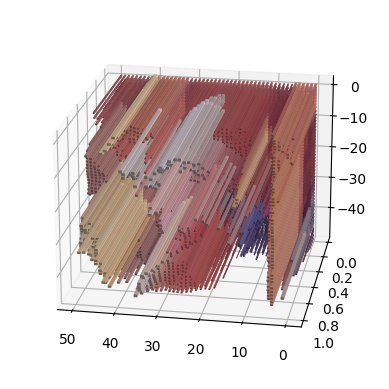

In [ ]:
#3D image
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def convert_to_cubixel(image_path):
    # Load the image
    img = Image.open(image_path)
    img = img.resize((50, 50))  # Resize for simplicity
    pixels = np.array(img)

    # Prepare 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Iterate over each pixel
    for i in range(pixels.shape[0]):
        for j in range(pixels.shape[1]):
            r, g, b = pixels[i, j][:3]

            # Define cube dimensions based on color values
            depth =  r/255
            width =  g/255
            height = b/255

            # Define cube position (adjust for correct orientation)
            zpos = r/255 -i
            xpos = j
            ypos = 0

            # Draw cube
            ax.bar3d(xpos, ypos, zpos, width, depth, height, color=[r/255.0, g/255.0, b/255.0], alpha=0.8)

    # Adjust the view angle if necessary
    ax.view_init(elev=20, azim=100)

    # Display the plot
    plt.show()

convert_to_cubixel('img.jpeg')


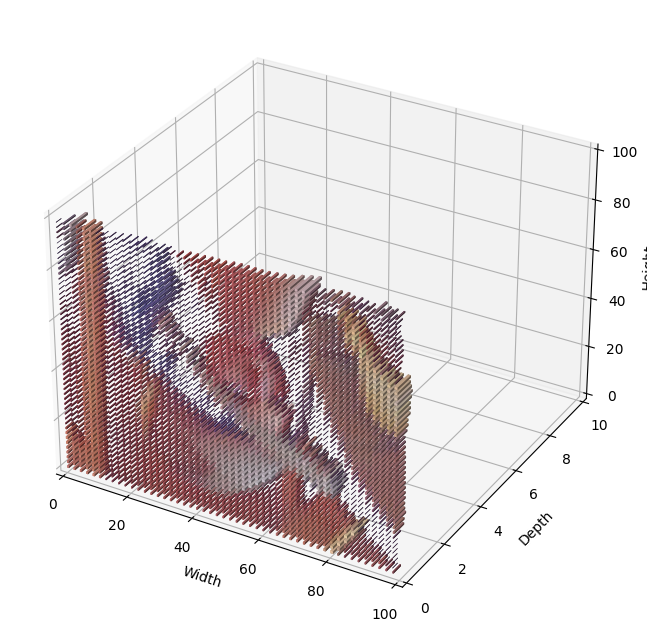

In [ ]:
#3D image with gaps
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the input image and convert it to a numpy array
input_image_path = 'img.jpeg'
img = Image.open(input_image_path)
img.thumbnail((50, 50))  # using thumbnail instead of resize to maintain aspect ratio
pixels = np.array(img)

# Define a new figure for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Variables to store the maximum dimensions of the grid, assuming each cubixel can have a unit size gap around it
grid_width = pixels.shape[1] * 2
grid_height = pixels.shape[0] * 2

# The function to calculate the depth based on the red color value
def calculate_depth(color_value):
    return color_value / 255.0

# Plot each pixel as a cube (cubixel)
for x in range(pixels.shape[1]):  # width of the image
    for y in range(pixels.shape[0]):  # height of the image
        # Pixel color
        color = pixels[y, x] / 255.0
        # Cube size is determined by color intensity
        # We use red channel for depth, green for width, blue for height
        depth = calculate_depth(pixels[y, x][0])
        width = calculate_depth(pixels[y, x][1])
        height = calculate_depth(pixels[y, x][2])

        # Calculate the position with gaps
        xpos = x * 2  # Double the x-coordinate to include the gap
        zpos = y * 2  # Double the y-coordinate to include the gap
        ypos = 0  # Set the y-coordinate to 0 as we are not stacking cubes on top of each other

        # Draw the cubixel
        ax.bar3d(xpos, ypos, zpos, width, height, depth, color=color)

# Set the labels
ax.set_xlabel('Width')
ax.set_ylabel('Depth')
ax.set_zlabel('Height')

# Set the axis limits
ax.set_xlim([0, grid_width])
ax.set_ylim([0, 10])  # Depth is constant as we are not stacking
ax.set_zlim([0, grid_height])

# Show the plot
plt.show()


<ipython-input-40-1d98ae9aa5c8>:48: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((128, 128), Image.ANTIALIAS)


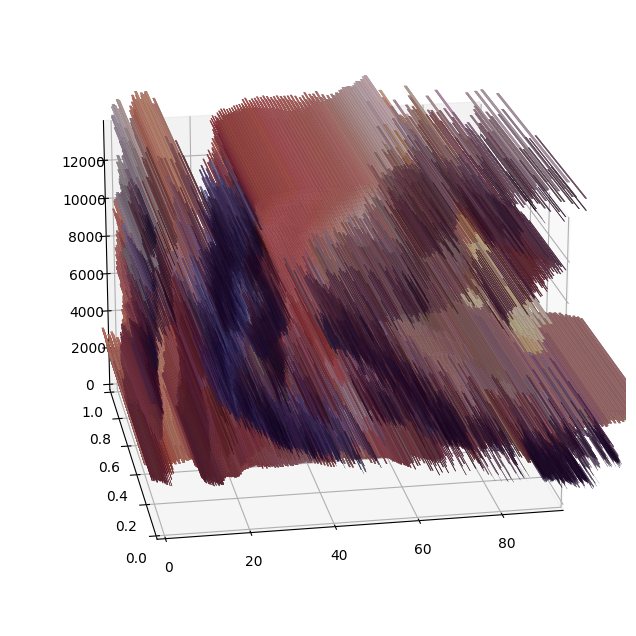

In [ ]:
#3D image with relative gaps
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def calculate_positions(pixels):
    """
    Calculate the 3D positions of each Cubixel, with dynamic gaps based on size differences.
    """
    positions = []
    prev_row_max_height = 0
    max_depth = 0

    for y in range(pixels.shape[0]):
        row_positions = []
        current_x_offset = 0
        max_height_in_row = 0
        prev_width = 0  # Initialize previous width for the first Cubixel

        for x in range(pixels.shape[1]):
            r, g, b = pixels[y, x][:3]
            width = g / 255.0
            height = b / 255.0
            depth = r / 255.0
            max_depth = max(max_depth, depth)

            gap = (prev_width + width) / 2  if x > 0 else 0
            current_x_offset += prev_width / 2 + gap if x > 0 else width / 2

            zpos = y * (prev_row_max_height + height / 2 ) if y > 0 else 0
            row_positions.append((current_x_offset, depth / 2, zpos, width, depth, height, x, y))

            current_x_offset += width / 2
            max_height_in_row = max(max_height_in_row, height)
            prev_width = width

        prev_row_max_height += max_height_in_row
        positions.append(row_positions)

    total_width = current_x_offset
    total_height = prev_row_max_height * pixels.shape[0]

    return positions, total_width, total_height, max_depth

def convert_to_cubixel(image_path):
    img = Image.open(image_path)
    img.thumbnail((128, 128), Image.ANTIALIAS)
    pixels = np.array(img)

    positions, total_width, total_height, max_depth = calculate_positions(pixels)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim([0, total_width])
    ax.set_ylim([0, max_depth])  # Y-axis dynamically set based on the maximum depth
    ax.set_zlim([0, total_height])

    for row in positions:
        for xpos, ypos, zpos, width, depth, height, pixel_x, pixel_y in row:
            color = pixels[pixel_y, pixel_x, :3] / 255.0
            ax.bar3d(xpos, ypos, zpos, width, depth, height, color=color)

    ax.view_init(elev=20, azim=-100)
    plt.show()

convert_to_cubixel('img.jpeg')


In [ ]:
# Segmentation based on gaps
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
def calculate_positions_and_segment(pixels, gap_threshold=0.5):
    """
    Calculate the 3D positions of each Cubixel and segment the image based on high gaps.
    """
    positions = []
    segments = []
    current_segment = []

    prev_row_max_height = 0

    for y in range(pixels.shape[0]):
        current_x_offset = 0
        max_height_in_row = 0
        prev_width = 0

        for x in range(pixels.shape[1]):
            r, g, b = pixels[y, x][:3]
            width = g / 255.0
            height = b / 255.0
            depth = r / 255.0

            gap = (prev_width + width) / 2 if x > 0 else 0
            current_x_offset += prev_width / 2 + gap if x > 0 else width / 2

            zpos = y * (prev_row_max_height + height / 2) if y > 0 else 0
            positions.append((current_x_offset, depth / 2, zpos, width, depth, height, x, y))

            current_x_offset += width / 2
            max_height_in_row = max(max_height_in_row, height)
            prev_width = width

            # Add the pixel to the current segment or start a new one if the gap is large
            if gap > gap_threshold:
                if current_segment:
                    segments.append(current_segment)
                    current_segment = []
            current_segment.append((x, y))

        prev_row_max_height += max_height_in_row

    # Add the last segment if it exists
    if current_segment:
        segments.append(current_segment)

    return positions, segments

# Example usage
pixels = np.array(Image.open('img.jpeg'))
positions, segments = calculate_positions_and_segment(pixels)

# For demonstration, let's print the first few segments
for i, segment in enumerate(segments[:5]):
    print(f"Segment {i+1}: {segment}")
def merge_small_segments(segments, merge_threshold=10):
    """
    Merge segments that are smaller than the merge_threshold into their nearest neighbors.
    """
    merged_segments = []
    for segment in segments:
        if len(segment) < merge_threshold:
            # Find the nearest segment and merge
            # For simplicity, we'll merge with the last segment in the merged list
            if merged_segments:
                merged_segments[-1].extend(segment)
        else:
            merged_segments.append(segment)
    return merged_segments
def mark_segments_on_image(image, segments):
    """
    Mark the detected regions on the original image with unified colors for each segment.
    """
    img_array = np.array(image)
    height, width, _ = img_array.shape

    # Instead of generating a unique color for each pixel in the segment,
    # generate one color per segment.
    colors = [tuple(np.random.randint(0, 255, 3)) for _ in range(len(segments))]

    # Mark each segment with its unique color
    for color, segment in zip(colors, segments):
        for x, y in segment:
            if 0 <= x < width and 0 <= y < height:
                img_array[y, x] = color  # Assign the same color to all pixels in the segment

    return Image.fromarray(img_array)


# Example usage
original_image = Image.open('img.jpeg')

pixels = np.array(original_image)
positions, segments = calculate_positions_and_segment(pixels)

# Post-process the segments to merge those that are close to each other
segments = merge_small_segments(segments)

# Generate a unique color for each segment
colors = [tuple(np.random.choice(range(256), size=3)) for i in range(len(segments))]

# Function to mark segments with a unique color on the image
def mark_segments_on_image(image, segments, colors):
    img_array = np.array(image)
    for color, segment in zip(colors, segments):
        for x, y in segment:
            img_array[y, x] = color  # Apply the same color to the whole segment
    return Image.fromarray(img_array)

# Mark the segments on the original image
marked_image = mark_segments_on_image(original_image, segments, colors)

# Display the image with marked regions using matplotlib
plt.imshow(marked_image)
plt.axis('off')  # Turn off axis numbers and labels
plt.show()

In [ ]:
# Seg based on horizantal and vertical gaps
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Redefining the calculate_positions_and_segment function.
def calculate_positions_and_segment(pixels, gap_threshold=0.5):
    positions = []
    segments = []
    current_segment = []
    segment_map = np.zeros((pixels.shape[0], pixels.shape[1]), dtype=int) - 1

    prev_row_max_height = 0
    segment_id = 0

    for y in range(pixels.shape[0]):
        current_x_offset = 0
        max_height_in_row = 0
        prev_width = 0

        for x in range(pixels.shape[1]):
            r, g, b = pixels[y, x][:3]
            width = g / 255.0
            height = b / 255.0
            depth = r / 255.0

            horizontal_gap = (prev_width + width) / 2 if x > 0 else 0
            vertical_gap = prev_row_max_height / 2 if y > 0 else 0

            current_x_offset += prev_width / 2 + horizontal_gap if x > 0 else width / 2
            zpos = y * (prev_row_max_height + height / 2) if y > 0 else 0
            positions.append((current_x_offset, depth / 2, zpos, width, depth, height, x, y))

            if x > 0 and horizontal_gap > gap_threshold or (y > 0 and vertical_gap > gap_threshold and segment_map[y - 1, x] != segment_id):
                if current_segment:
                    segments.append(current_segment)
                    current_segment = []
                    segment_id += 1

            current_segment.append((x, y))
            segment_map[y, x] = segment_id

            current_x_offset += width / 2
            max_height_in_row = max(max_height_in_row, height)
            prev_width = width

        prev_row_max_height = max_height_in_row

    if current_segment:
        segments.append(current_segment)

    return positions, segments, segment_map

# Function to color each segment with a unified color.
def color_segments(segment_map):
    unique_segments = np.unique(segment_map)
    colors = {seg_id: tuple(np.random.choice(range(256), size=1)) for seg_id in unique_segments if seg_id != -1}

    colored_image = np.zeros((*segment_map.shape, 3), dtype=np.uint8)
    for seg_id, color in colors.items():
        colored_image[segment_map == seg_id] = color

    return Image.fromarray(colored_image)

# Load the image from the saved path

def mark_segments_on_image(image, segments):
    """
    Mark the detected regions on the original image with unified colors for each segment.
    """
    img_array = np.array(image)
    height, width, _ = img_array.shape

    # Instead of generating a unique color for each pixel in the segment,
    # generate one color per segment.
    colors = [tuple(np.random.randint(0, 255, 3)) for _ in range(len(segments))]

    # Mark each segment with its unique color
    for color, segment in zip(colors, segments):
        for x, y in segment:
            if 0 <= x < width and 0 <= y < height:
                img_array[y, x] = color  # Assign the same color to all pixels in the segment

    return Image.fromarray(img_array)


# Example usage
original_image = Image.open('img.jpeg')

pixels = np.array(original_image)
positions, segments,_ = calculate_positions_and_segment(pixels)
#segments = merge_small_segments(segments)

# Post-process the segments to merge those that are close to each other

# Generate a unique color for each segment
def mark_segments_on_image_with_white(image, segments, colors):
    img_array = np.array(image)
    height, width, _ = img_array.shape

    for color, segment in zip(colors, segments):
        for i, (x, y) in enumerate(segment):
            # Check if the next pixel is not part of the same segment
            if i+1 < len(segment):
                next_x, _ = segment[i+1]
                _, prev_y = segment[i-1]

                if next_x != x+1:
                    img_array[y, x] = (0, 0, 255)  # Color the current pixel white
                else:
                    img_array[y, x] =(255,0,0)  # Apply the same color to the current pixel
            else:
                img_array[y, x] =(255, 255, 255)  # Apply the same color to the last pixel in the segment
    return Image.fromarray(img_array)

# Generate a unique color for each segment
colors = [tuple(np.random.choice(range(256), size=3)) for i in range(len(segments))]

# Mark the segments on the original image with a unique color for each segment,
# and color the current pixel white if the next pixel is not part of the same segment.
marked_image_with_white = mark_segments_on_image_with_white(original_image, segments, colors)

# Display the image with marked regions using matplotlib
plt.imshow(marked_image_with_white)
plt.axis('off')  # Turn off axis numbers and labels
plt.show()

Percentile-based threshold: 0.07735035568475723


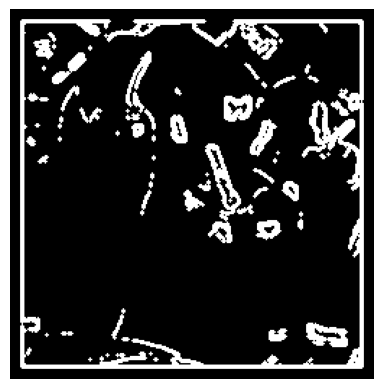

In [ ]:
#Volume of the Void
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, generate_binary_structure

def calculate_void_volume(cubixel1, cubixel2):
    volume1 = np.prod(cubixel1, axis=-1)  # The product of RGB values for the first cubixel
    volume2 = np.prod(cubixel2, axis=-1)  # The product of RGB values for the second cubixel
    void_volume = np.abs(volume1 - volume2)  # The absolute difference between volumes
    return void_volume

def detect_edges(image_path, percentile_value):
    # Load the image (RGB)
    img = Image.open(image_path)
    img.thumbnail((256, 256))

    img = img.filter(ImageFilter.MedianFilter(size=3))  # Apply median filter for noise reduction
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0, 1]

    height, width, _ = img_array.shape
    edge_map = np.zeros((height, width), dtype=np.uint8)  # Output is a binary edge map
    void_volumes = np.zeros((height, width), dtype=np.float32)

    # Calculate void volumes for each pixel
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            max_local_void = 0
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    local_void = calculate_void_volume(img_array[i, j], img_array[i + di, j + dj])
                    max_local_void = max(max_local_void, local_void)
            void_volumes[i, j] = max_local_void

    # Use a percentile-based threshold to find edges
    threshold = np.percentile(void_volumes, percentile_value)  # Keep the top x% of void volume values
    print(f"Percentile-based threshold: {threshold}")

    # If the threshold is too high, adjust it based on the range of void volumes
    if threshold > 0.1 * np.ptp(void_volumes):  # ptp: peak-to-peak value (max - min)
        threshold = 0.1 * np.ptp(void_volumes)
        print(f"Adjusted threshold: {threshold}")

    edge_map[void_volumes >= threshold] = 255

    # Apply morphological opening to clean up noise
    structure = generate_binary_structure(2, 1)
    edge_map = binary_opening(edge_map, structure=structure).astype(np.uint8) * 255

    return Image.fromarray(edge_map)
# Set a lower percentile to include more edges
percentile_value = 85  # Adjust percentile as needed

# Deteect edges in the image
edge_map_image = detect_edges('paper.jpg',percentile_value)

# Display the edge map
plt.imshow(edge_map_image, cmap='gray')
plt.axis('off')
plt.show()


Time elapsed: 0.06 seconds


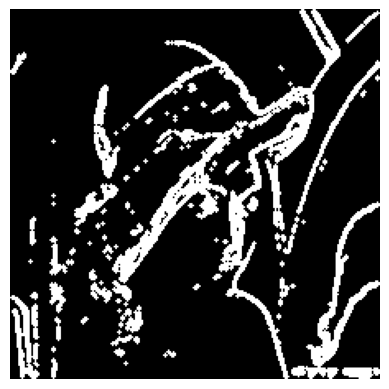

In [ ]:
#Fast VoV Edge detection
import numpy as np
from PIL import Image, ImageFilter
from scipy.ndimage import generate_binary_structure, binary_opening
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, generate_binary_structure
import time
def calculate_void_volume(cubixel1, cubixel2):
    # Vectorized computation of volumes and their absolute differences
    volume1 = np.prod(cubixel1, axis=-1)
    volume2 = np.prod(cubixel2, axis=-1)
    void_volume = np.abs(volume1 - volume2)
    return void_volume

def detect_edges(image_path, percentile_value):
    # Load and preprocess the image
    img = Image.open(image_path)
    img.thumbnail((256, 256))
    img = img.filter(ImageFilter.MedianFilter(size=3))
    img_array = np.array(img, dtype=np.float32) / 255.0

    height, width, _ = img_array.shape
    void_volumes = np.zeros((height, width), dtype=np.float32)

    # Vectorized computation of void volumes
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if di == 0 and dj == 0:
                continue
            # Compute volumes for neighboring pixels
            neighbor_pixels = np.roll(np.roll(img_array, di, axis=0), dj, axis=1)
            local_void = calculate_void_volume(img_array, neighbor_pixels)
            void_volumes = np.maximum(void_volumes, local_void)

    # Calculate percentile-based threshold
    threshold = np.percentile(void_volumes, percentile_value)

    # Adjust the threshold if necessary
    if threshold > 0.1 * np.ptp(void_volumes):
        threshold = 0.1 * np.ptp(void_volumes)

    # Generate edge map
    edge_map = (void_volumes >= threshold).astype(np.uint8) * 255

    # Apply morphological opening
    structure = generate_binary_structure(2, 1)
    edge_map = binary_opening(edge_map, structure=structure).astype(np.uint8) * 255

    return Image.fromarray(edge_map)

# Example usage
percentile_value = 80
start = time.time()
edge_map_image = detect_edges('img.jpeg', percentile_value)
print(f"Time elapsed: {time.time() - start:.2f} seconds")
# Display the edge map
plt.imshow(edge_map_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
#ViT efficientnet InceptionV3
def build_efficientnet_model():
    # Load the pre-trained EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

    # Freeze the base_model
    base_model.trainable = False

    # Create the input layer
    inputs = Input(shape=input_shape)

    # Use the EfficientNetB0 model as the base
    x = base_model(inputs, training=False)  # Make sure the base model is running in inference mode here

    # Add GlobalAveragePooling2D layer to reduce feature maps size
    x = GlobalAveragePooling2D()(x)

    # Add a Dense layer with a softmax activation for the classification
    outputs = Dense(7, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs, outputs)

    return model

def build_InceptionV3_model():
    # Load the pre-trained InceptionV3 model without the top layer
    base_model = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')

    # Freeze the base_model
    base_model.trainable = False

    # Create the input layer
    inputs = Input(shape=input_shape)

    # Use the InceptionV3 model as the base
    x = base_model(inputs, training=False)  # Make sure the base model is running in inference mode here

    # Add GlobalAveragePooling2D layer to reduce feature maps size
    x = GlobalAveragePooling2D()(x)

    # Add a Dense layer with a softmax activation for the classification
    outputs = Dense(7, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs, outputs)

    return model
def build_vit_model( ):
    input_layer = Input(input_shape)
    vit_model = vit.vit_b32(
        image_size=input_shape[0],
        activation='softmax',
        pretrained=True,
        include_top=True,
        pretrained_top=False,
        classes=7
    )(input_layer)
